In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import hdf5plugin
import h5py

import sys
import os

sys.path.insert(0, '../src/')
from temporal_autocorrelation import *
from mask_tools import * 
from fit_tools import *
from parameters import *
from masking_streaks import *

plot_save=False

### open hdf5 file 

Note that the hdf5plugin must be installed (pip install hdf5plugin)

In [2]:
sample_name = 'ehda_dp63_c'
run_num     = 10
file_name = '%s_%05d_data_%06d.h5'%(sample_name,run_num,1)
file_path = '../data/'+file_name
h5file = h5py.File(file_path, 'r')
data = h5file['entry/data/data/']
print file_name

ehda_dp63_c_00010_data_000001.h5


In [3]:
avg_data = np.sum(data,axis=0)/float(data.shape[0])

### load mask and parameters

In [4]:
mask = np.load('../masks/eiger_mask.npy')
dpix,Ldet,center  = eiger_parameters()

### Reduce size

reduce array size to speed up the calculation

In [5]:
sxy = 120
dx = [center[0]-sxy,center[0]+sxy]
dy = [center[1]-sxy,center[1]+sxy]

data_small = data[:,dx[0]:dx[1],dy[0]:dy[1]]
center_small = [center[0]-dx[0],center[1]-dy[0]]
mask_small = mask[dx[0]:dx[1],dy[0]:dy[1]]
avg_data_small = avg_data[dx[0]:dx[1],dy[0]:dy[1]]

### Radial integration

In [6]:
phi,Iphi = radial_average(avg_data_small,mask=mask_small, center=center_small,nx=300)
#Iphi/=np.average(Iphi)

/Users/fivos/pyvos/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/Users/fivos/pyvos/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in multiply


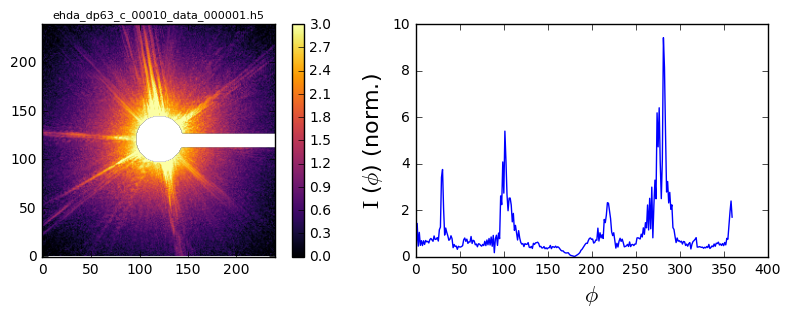

In [7]:
plt.figure(figsize=[10,3])
plt.subplot(1,2,1)
plt_data = np.log10(avg_data[dx[0]:dx[1],dy[0]:dy[1]]*mask_small)
plt.imshow(plt_data*mask_small,vmax=3,vmin=0,origin='lower',cmap='inferno')
plt.colorbar()
plt.title(file_name,size=8)

plt.subplot(1,2,2)
plt.plot(phi,Iphi/np.average(Iphi),'-')
plt.ylabel(r'$\rm I$ ($\phi$) (norm.)',size=16)
plt.xlabel(r'$\phi$',size=16)
#plt.xlim([0,360])
plt.show()

### Mask streaks

In [12]:
threshold = 1.2
phi_mask = mask_streaks(avg_data_small,mask=mask_small,center=center_small,threshold=threshold)
phi2,Iphi2 = radial_average(avg_data_small,mask=mask_small*phi_mask, center=center_small,nx=300)

/Users/fivos/pyvos/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


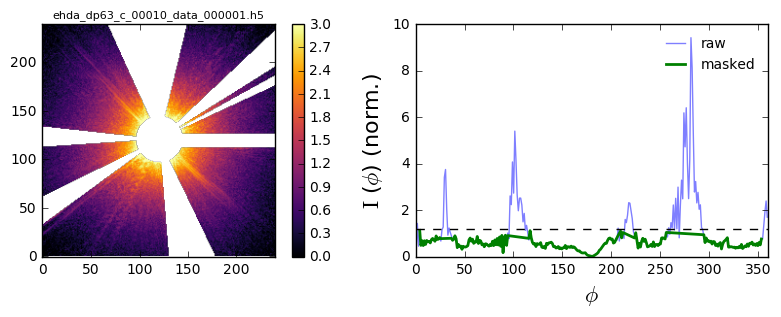

In [31]:
plt.figure(figsize=[10,3])
plt.subplot(1,2,1)
plt_data = np.log10(avg_data[dx[0]:dx[1],dy[0]:dy[1]]*mask_small*phi_mask)
plt.imshow(plt_data,vmax=3,vmin=0,origin='lower',cmap='inferno')
plt.colorbar()
plt.title(file_name,size=8)

plt.subplot(1,2,2)

plt.plot(phi,Iphi/np.average(Iphi),'-',alpha=0.5,label='raw')
plt.plot(phi2,Iphi2/np.average(Iphi),'-',c='green',lw=2,label='masked')
plt.legend(frameon=False,loc='upper right', prop={'size': 10})
plt.axhline(y=threshold,ls='--',c='black',label='threshold')
plt.ylabel(r'$\rm I$ ($\phi$) (norm.)',size=16)
plt.xlabel(r'$\phi$',size=16)
plt.xlim([0,360])
plt.show()

### temporal autocorrelation g2

calculate g2

In [14]:
qt,dt,g2,r_mask = calculate_g2(data_small,mask=mask_small,center=center_small)
qt,dt,g2_2,r_mask = calculate_g2(data_small,mask=mask_small*phi_mask,center=center_small)

make plots

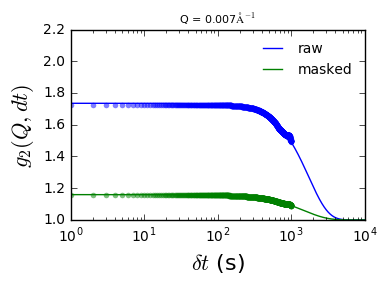

In [28]:
plt.figure(figsize=[4,3])

i=0

plt.plot(dt,g2[:,i],'o',alpha=0.5,c='blue',ms=4,markeredgecolor='None') 
popt,x,curve,perr = fit(stretched_exponential,dt,g2[:,i],p0=[0.06,1e3,1])
plt.plot(x,curve,c='blue',ls='-',lw=1,label='raw')

plt.plot(dt,g2_2[:,i],'o',alpha=0.5,c='green',ms=4,markeredgecolor='None') 
popt,x,curve2,perr = fit(stretched_exponential,dt,g2_2[:,i],p0=[0.06,1e3,1])
plt.plot(x,curve2,c='green',ls='-',lw=1,label='masked')

plt.xlabel(r'$\delta t$ (s)',size=16)
plt.ylabel(r'$g_{2}(Q,dt)$ ',size=16)
plt.xscale('log',nonposy='clip')
plt.xlim([1,1e4])
plt.ylim([1.0,2.2])
plt.legend(frameon=False,loc='upper right', prop={'size': 10})
plt.title(r'Q = %.3f$\rm \AA^{-1}$'%qt[i],size=8)
plt.tight_layout()
if plot_save==True:
    plt.savefig('/Users/fivos/Desktop/fig.png',dpi=300)
plt.show()


Save results

In [ ]:
if plot_save==True:
    np.save('/Users/fivos/Desktop/data.npy',np.array(dt,g2_2[:,0]))